In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import gc

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.linalg
import copy
import sklearn
import rastermap
import pandas as pd
from tqdm.notebook import tqdm

import tensorly as tl
import tensorly.decomposition
import torch

In [3]:
# dir_github        = Path(r'D:\RH_local\github').resolve()

# dir_analysisFiles = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L').resolve()
dir_analysisFiles = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6/').resolve()

## Directory with F.npy, stat.npy etc.
# dir_s2p         = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_1511L/statFiles/20230111').resolve()
dir_s2p         = Path(r'/media/rich/bigSSD/data_raw/BMI/mouse_2_6/statFiles/20210409').resolve()
# dir_s2p         = Path(r'C:\Users\Rich Hakim\Downloads\F.npy').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'
# path_save = dir_save / 'weights_day0_PC2'

In [4]:
# import sys
# sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2
from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity, spectral, featurization, decomposition

%load_ext autoreload
%autoreload 2
import roicat

# %load_ext autoreload
# %autoreload 2
# from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
device = torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [6]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [7]:
DEVICE = torch_helpers.set_device(use_GPU=True);

devices available: [_CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)]
Using device: 'cuda:0': _CudaDeviceProperties(name='NVIDIA GeForce RTX 3090', major=8, minor=6, total_memory=24226MB, multi_processor_count=82)


In [8]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [9]:
tqm = file_helpers.pickle_load(path_tqm)
dFoF_params = tqm['dFoF_params']

In [10]:
## == IMPORT DATA ==
F, Fneu, iscell_s2p, ops, spks_s2p, stat = ca2p_preprocessing.import_s2p(dir_s2p)
n_frames, n_rois = F.shape[1], F.shape[0]
Fs = ops['fs']

iscell.npy not found in /media/rich/bigSSD/data_raw/BMI/mouse_2_6/statFiles/20210409


In [11]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F = np.delete(F, range(43000,50000), axis=1)
# Fneu = np.delete(Fneu, range(43000,50000), axis=1)

In [12]:
Fneu.shape

(4898, 108000)

In [13]:
frame_height, frame_width = ops['meanImg'].shape[0], ops['meanImg'].shape[1]

# sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

data_rois = roicat.data_importing.Data_suite2p([dir_s2p / 'stat.npy'], FOV_height_width=(frame_height, frame_width))
sf = data_rois.spatialFootprints[0]

Completed: Set FOV_height and FOV_width successfully.
Importing spatial footprints from stat files.


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


# Prepare dFoF

In [14]:
idx_time_bad = np.arange(0,0)

idx_time_good = np.arange(n_frames)[~np.isin(np.arange(n_frames), idx_time_bad)]

In [15]:
F_toUse = F[iscell][:, idx_time_good]
Fneu_toUse = Fneu[iscell][:, idx_time_good]

In [16]:
# dFoF with reduced percentile for baseline
channelOffset_correction = 0
percentile_baseline = 20
neuropil_fraction = 0.7
win_rolling_percentile = 15*60*30

dFoF, dF, F_neuSub, F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_toUse,
    Fneu=Fneu_toUse,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    rolling_percentile_window=win_rolling_percentile,
    multicore_pref=True,
    verbose=True
)
# # Threshold for nonnegativity
# dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|███████████████████████████████████████████| 36/36 [00:21<00:00,  1.67it/s]


Calculated dFoF. Total elapsed time: 25.7 seconds


In [17]:
dFoF[F_baseline < 5] = np.nan
dFoF = np.nan_to_num(dFoF)

### Look at rastermap

In [18]:
import rastermap

# Pre-orthogonalization

### Define traces to orthogonalize out:
- Mean neuron trace (average vector)
    - multiple frequency components
- Mean neuropil trace
    - multiple frequency components

In [19]:
dFoF_mean = np.nanmean(dFoF, axis=0)
Fneu_mean = np.nanmean(Fneu_toUse, axis=0)

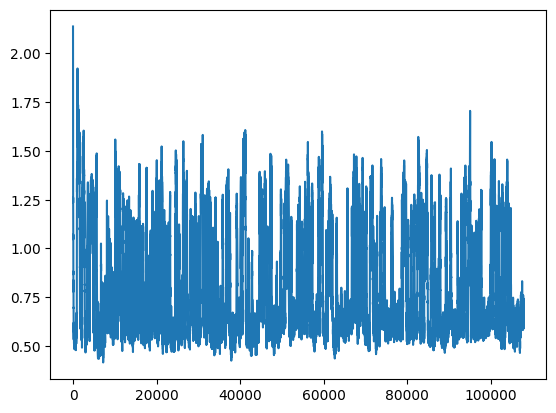

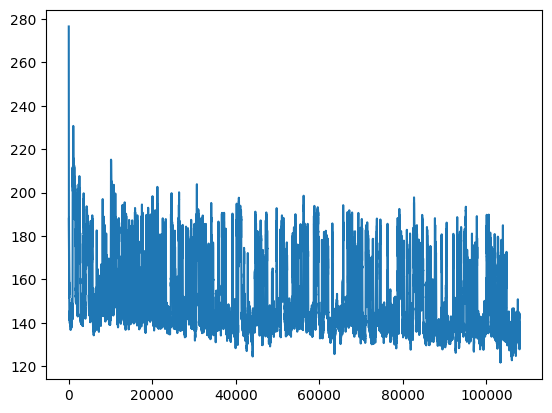

In [20]:
plt.figure()
plt.plot(dFoF_mean)

plt.figure()
plt.plot(Fneu_mean)

### spectral expansion

Make a set of band pass filter, then filter traces with each filter

In [21]:
bandpass_freqs_boundaries = [0, 1/(60*5), 1/20, 1/2, 5, np.inf]

bandpass_ab = [spectral.design_fir_bandpass(bp_1, bp_2, num_taps=10001, fs=Fs, window=('kaiser', 3.0), plot_pref=False) for ii, (bp_1, bp_2) in enumerate(zip(bandpass_freqs_boundaries[:-1], bandpass_freqs_boundaries[1:]))]


In [22]:
traces = [spectral.plot_digital_filter_response(b=h, fs=Fs, worN=100000, plot_pref=False) for h in tqdm(bandpass_ab)]

  0%|          | 0/5 [00:00<?, ?it/s]

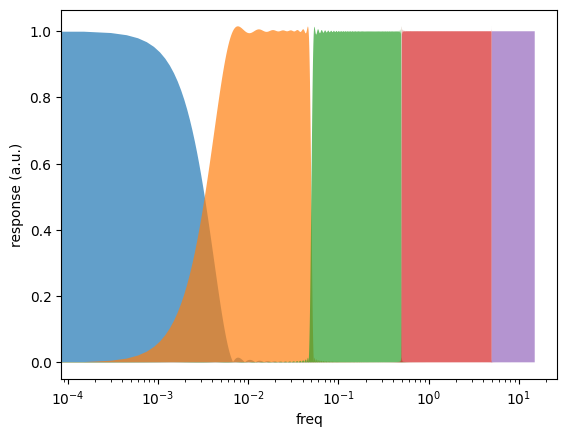

In [23]:
plt.figure()
[(plt.fill_between(t[0], t[1], alpha=0.7), plt.xscale('log'), plt.xlabel('freq'), plt.ylabel('response (a.u.)')) for t in traces];

In [24]:
sigs = np.stack(
    [scipy.signal.filtfilt(h, 1.0, dFoF_mean - dFoF_mean.mean()) for h in tqdm(bandpass_ab)] + \
    [scipy.signal.filtfilt(h, 1.0, Fneu_mean - Fneu_mean.mean()) for h in tqdm(bandpass_ab[:2])] + \
    [np.linspace(-1, 1, n_frames, endpoint=True)] + \
    [np.ones(n_frames)] + \
    list(featurization.mspline_grid(3, 5, n_frames)),
    
    axis=0
)

sigs = sigs - sigs.mean(1, keepdims=True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


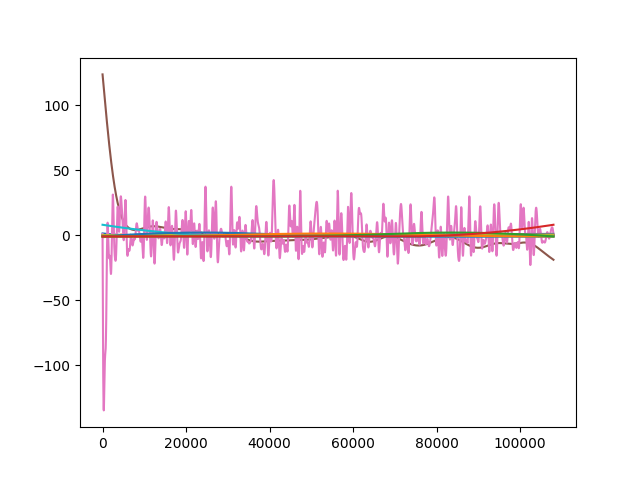

<IPython.core.display.Javascript object>


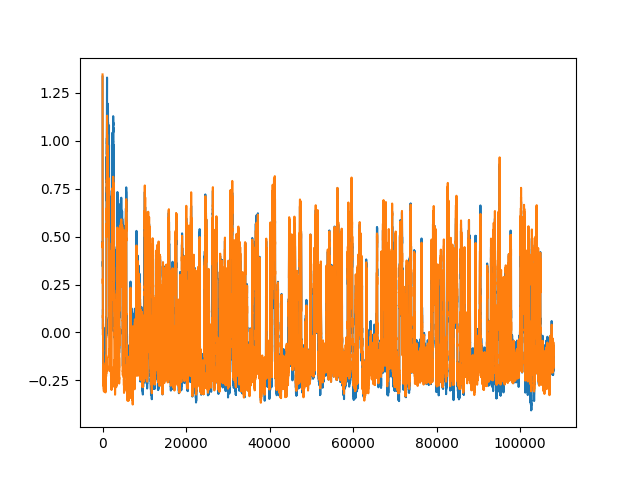

In [96]:
%matplotlib notebook

plt.figure()
plt.plot(sigs.T);

plt.figure()
plt.plot(sigs[:5].sum(0))
plt.plot(dFoF_mean - dFoF_mean.mean())

<IPython.core.display.Javascript object>


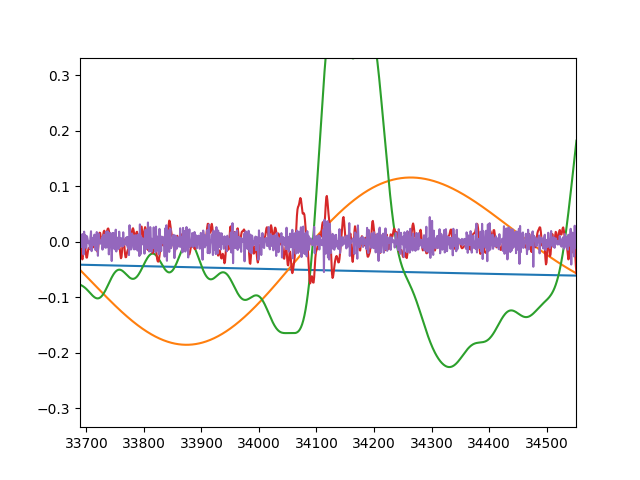

<IPython.core.display.Javascript object>


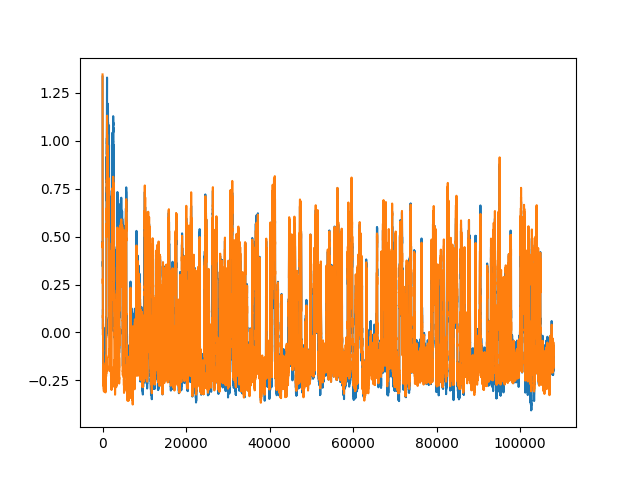

In [97]:
%matplotlib notebook

plt.figure()
plt.plot(sigs[:5].T);

plt.figure()
plt.plot(sigs[:5].sum(0))
plt.plot(dFoF_mean - dFoF_mean.mean())

In [26]:
dFoF_roiMeans = dFoF.mean(1, keepdims=True)

v1_orth, v2_PCs, EVR, EVR_total = similarity.orthogonalize((dFoF - dFoF_roiMeans).T, sigs.T)

dFoF_orth = v1_orth.T + dFoF_roiMeans

/media/rich/Home_Linux_partition/github_repos/basic_neural_processing_modules/bnpm/similarity.py:152: RuntimeWarning: invalid value encountered in divide
  EVR = 1 - (np.var(v1_orth, axis=0) / np.var(v1, axis=0))


In [27]:
dFoF_orth = dFoF_orth - np.percentile(dFoF_orth, percentile_baseline, axis=1)[:,None]

In [28]:
EVR_total

0.17188362670486224

In [29]:
import rastermap

In [30]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [31]:
X = dFoF_orth
rmap.fit(X)

nmin 200
0.6241092681884766
19.364212036132812
20.031192779541016
20.03595542907715
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.27s     0        0.1225      2
0.31s    10        0.2216      4
0.36s    20        0.2531      8
0.41s    30        0.2912      18
0.47s    40        0.3261      28
0.57s    50        0.3511      38
0.64s    60        0.3521      38
0.69s   final      0.3521
0.69s upsampled    0.3521


<IPython.core.display.Javascript object>


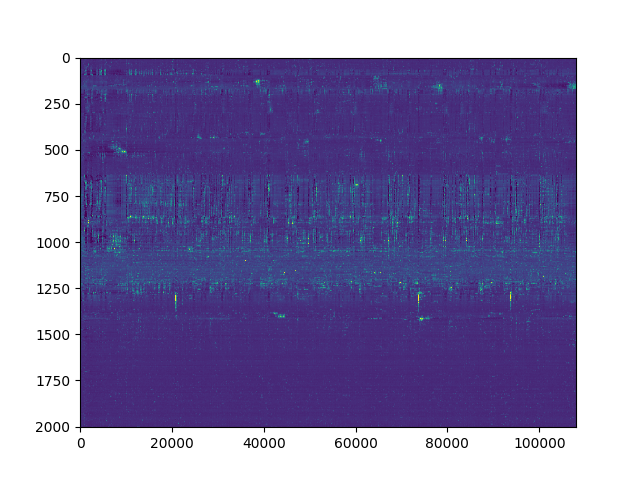

In [32]:
%matplotlib notebook

plt.figure()
plt.imshow(X[rmap.isort], aspect='auto', vmin=-1, vmax=10)

In [33]:
def orthogonalize_matrix(arr):
    means = arr.mean(1)
    arr_orth = arr - means[:,None]
    for ii in range(1, arr.shape[0]):
        arr_orth[ii] = similarity.orthogonalize(arr_orth[ii], arr_orth[:ii].T)[0].squeeze()

    return arr_orth + means[:,None]

In [34]:
def find_EVR_neuralData_factors(neural_data, factors, device='cpu'):
    """
    neural_data (torch.Tensor):
        shape: (neurons, time)
    factors (torch.Tensor):
        shape: (factor, time)
    """
    out = [similarity.pairwise_orthogonalization_torch(
        torch.as_tensor(neural_data).T.type(torch.float32).to(device), 
        torch.as_tensor(factors[ii]).type(torch.float32).to(device), 
        center=True,
        device=device) for ii in range(len(factors))]

    EVR_total_weighted = np.array([o[2].cpu().numpy() for o in out])
    EVR = np.stack([np.nan_to_num(o[1].cpu().numpy(), 0) for o in out], axis=0).T
    
    return EVR, EVR_total_weighted

In [35]:
def order_factors_by_EVR(factors, data, device='cpu'):
    EVR, EVR_total_weighted = find_EVR_neuralData_factors(data, factors, device=device)
    idx_ordered = np.argsort(EVR_total_weighted)[::-1]
    factors_ordered = factors[idx_ordered]
    
    return factors_ordered, idx_ordered

# Run NMF

In [36]:
neural_data_toUse = dFoF_orth.copy().astype(np.float32)
neural_data_toUse = np.clip(neural_data_toUse, a_min=0, a_max=None)
# neural_data_toUse = neural_data_toUse - neural_data_toUse.mean(1, keepdims=True)

In [37]:
tl.set_backend('pytorch')

In [38]:
# Roll a dice and wish for luck
rank = 8

In [39]:
tl.set_backend('pytorch')

In [40]:
nmf = tl.decomposition.CP_NN_HALS(
    rank=rank, 
    n_iter_max=1000, 
    init='svd',
    svd='truncated_svd',
    tol=1e-08,
    sparsity_coefficients=None,
    fixed_modes=None, 
    nn_modes='all', 
#     nn_modes=[1],  
    exact=False, 
    verbose=True, 
    normalize_factors=True, 
    cvg_criterion='abs_rec_error'
)
factors_nmf = nmf.fit_transform(torch.as_tensor(neural_data_toUse, dtype=torch.float32, device=device))

# factors_nmf = tl.decomposition.non_negative_parafac_hals(
#     tensor=torch.as_tensor(neural_data_toUse, dtype=torch.float32, device=device),
#     rank=rank, 
#     n_iter_max=1000, 
#     init='svd',
#     svd='truncated_svd',
#     tol=1e-07,
#     sparsity_coefficients=None,
#     fixed_modes=None, 
# #     nn_modes='all', 
#     nn_modes=(False, True), 
#     exact=False,
#     verbose=True,
#     normalize_factors=True,    
#     cvg_criterion='abs_rec_error'
# )

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


reconstruction error=0.7737607955932617
iteration 1, reconstruction error: 0.7586286664009094, decrease = 0.015132129192352295
iteration 2, reconstruction error: 0.753002941608429, decrease = 0.005625724792480469
iteration 3, reconstruction error: 0.7497678399085999, decrease = 0.0032351016998291016
iteration 4, reconstruction error: 0.7480470538139343, decrease = 0.0017207860946655273
iteration 5, reconstruction error: 0.7470870614051819, decrease = 0.0009599924087524414
iteration 6, reconstruction error: 0.7464156746864319, decrease = 0.00067138671875
iteration 7, reconstruction error: 0.7459062933921814, decrease = 0.0005093812942504883
iteration 8, reconstruction error: 0.745520830154419, decrease = 0.00038546323776245117
iteration 9, reconstruction error: 0.7452343702316284, decrease = 0.00028645992279052734
iteration 10, reconstruction error: 0.7450243830680847, decrease = 0.00020998716354370117
iteration 11, reconstruction error: 0.7448714971542358, decrease = 0.0001528859138488

In [64]:
factors_temporal_nmf = factors_nmf.factors[1].cpu().numpy().T
factors_neuron_nmf = factors_nmf.factors[0].cpu().numpy().T

In [65]:
scores_nmf = (neural_data_toUse.T @ factors_neuron_nmf.T).T

In [66]:
factors_neuron_nmf_orth = orthogonalize_matrix(factors_neuron_nmf)

In [67]:
scores_nmf_orth = (neural_data_toUse.T @ factors_neuron_nmf_orth.T).T

In [68]:
factors_neuron_nmf_orth_ms = factors_neuron_nmf_orth - factors_neuron_nmf_orth.mean(1, keepdims=True)
scores_nmf_orth_ms = (neural_data_toUse.T @ factors_neuron_nmf_orth_ms.T).T

In [69]:
_, order = order_factors_by_EVR(scores_nmf_orth_ms, neural_data_toUse, device='cuda')

In [81]:
factors_neuron_nmf_orth_ms_ordered = factors_neuron_nmf_orth_ms[order]
scores_nmf_orth_ms_ordered = (neural_data_toUse.T @ factors_neuron_nmf_orth_ms_ordered.T).T

In [71]:
torch_helpers.clear_cuda_cache()

<IPython.core.display.Javascript object>


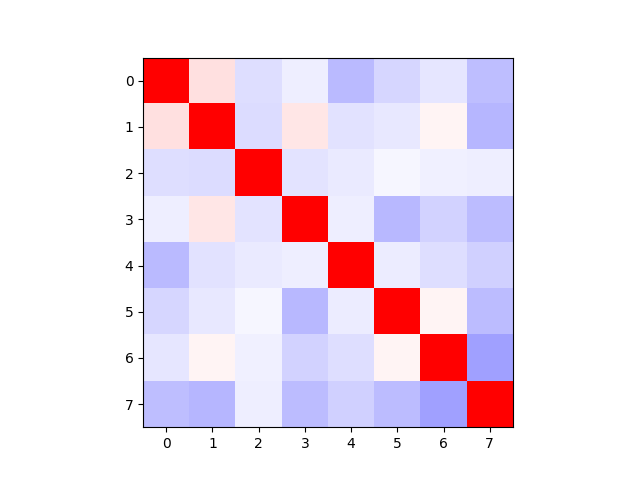

In [72]:
plt.figure()
plt.imshow(np.corrcoef(factors_temporal_nmf), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


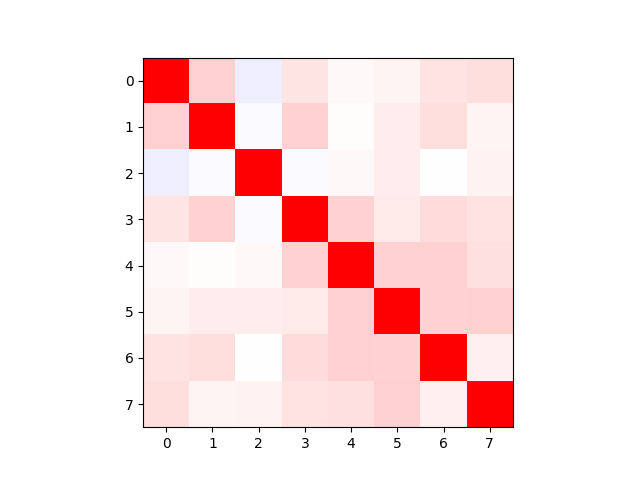

In [73]:
plt.figure()
plt.imshow(np.corrcoef(factors_neuron_nmf), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


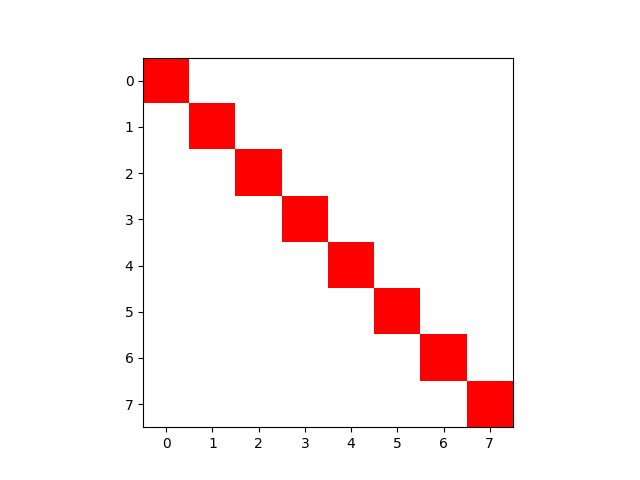

In [74]:
plt.figure()
plt.imshow(np.corrcoef(factors_neuron_nmf_orth), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


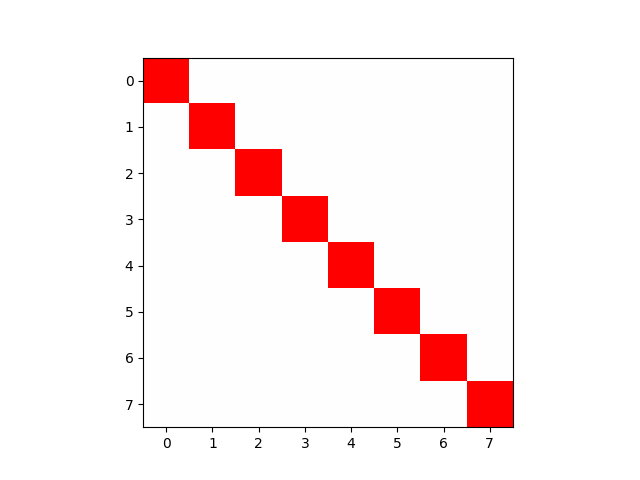

In [75]:
plt.figure()
plt.imshow(np.corrcoef(factors_neuron_nmf_orth_ms), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


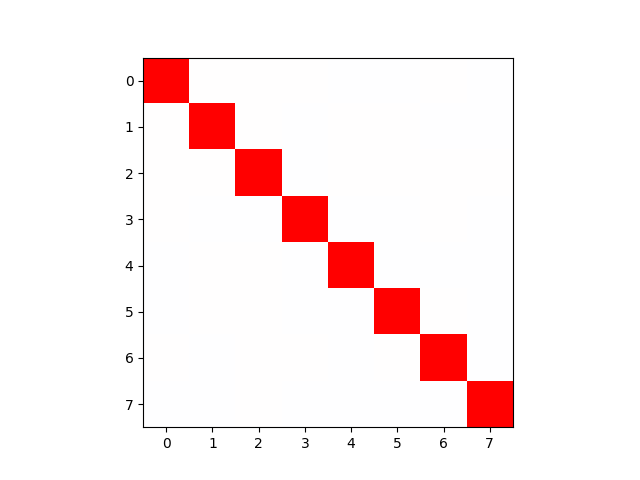

In [76]:
plt.figure()
plt.imshow(np.corrcoef(factors_neuron_nmf_orth_ms_ordered), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


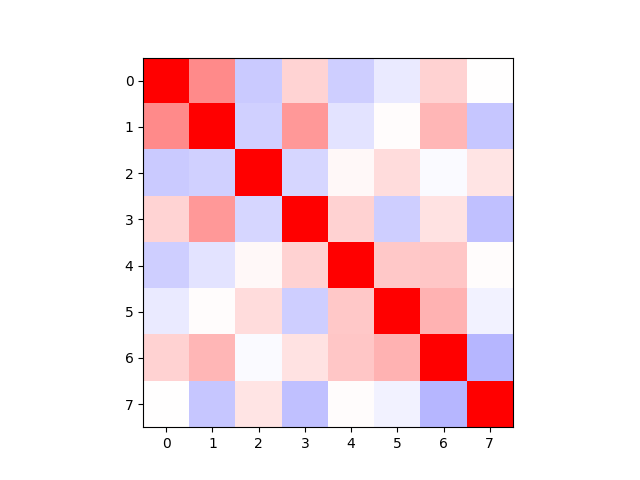

In [77]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


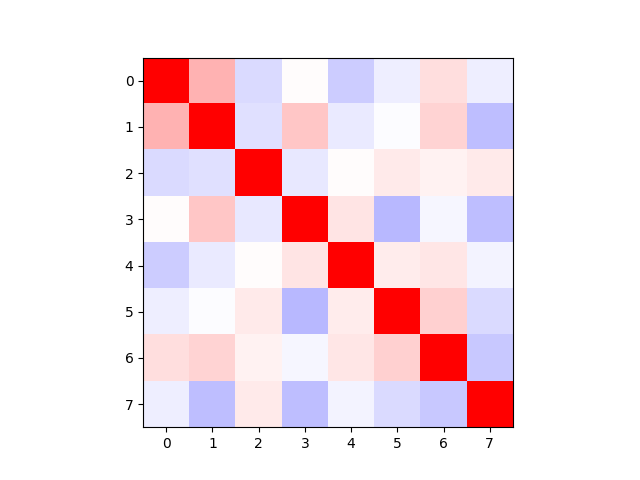

In [78]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf_orth), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


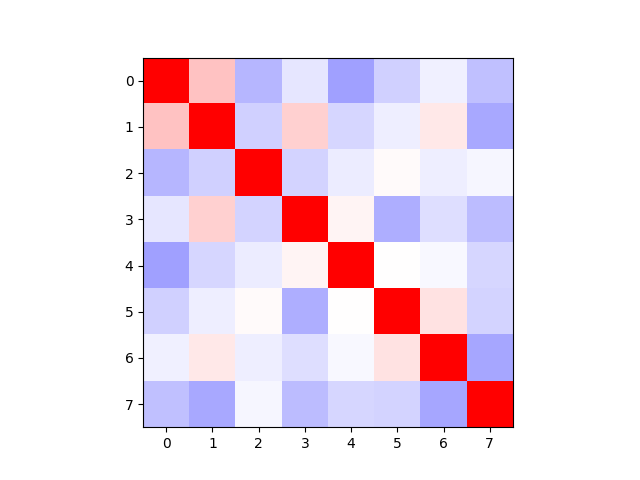

In [79]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf_orth_ms), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


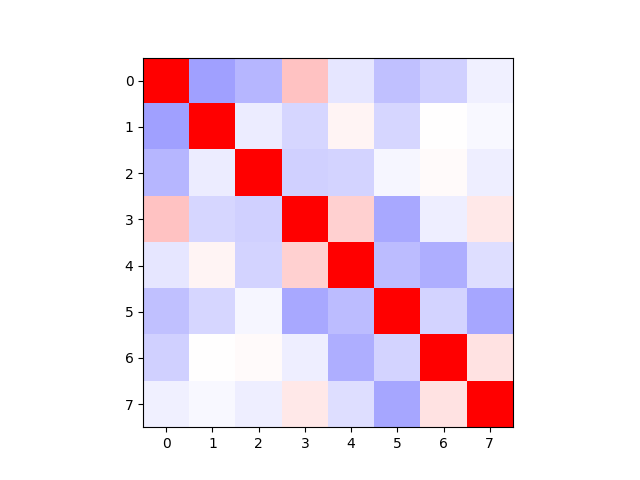

In [82]:
plt.figure()
plt.imshow(np.corrcoef(scores_nmf_orth_ms_ordered), cmap='bwr', clim=[-1,1])

<IPython.core.display.Javascript object>


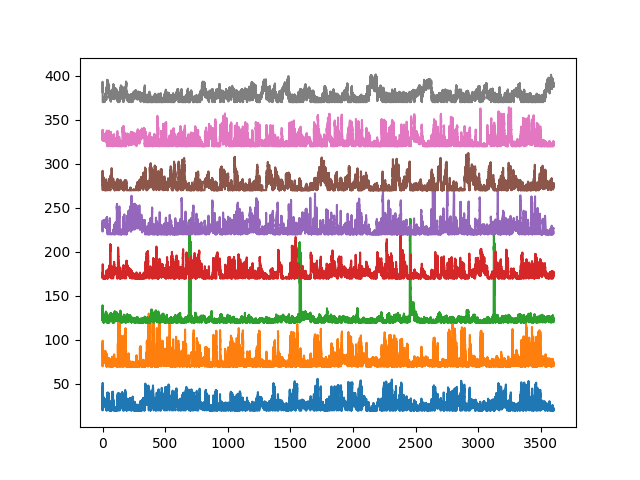

<IPython.core.display.Javascript object>


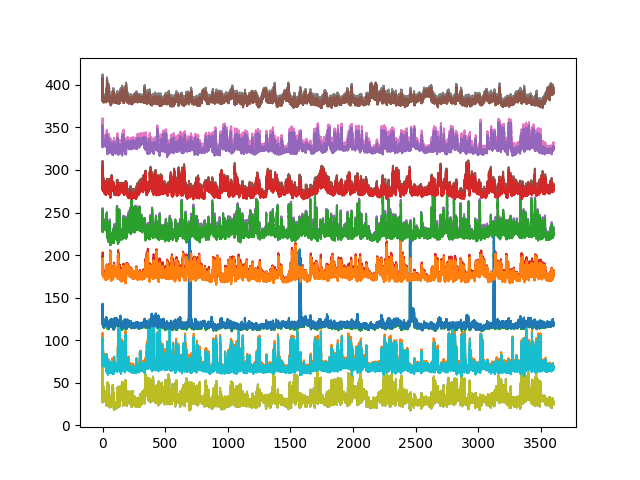

<IPython.core.display.Javascript object>


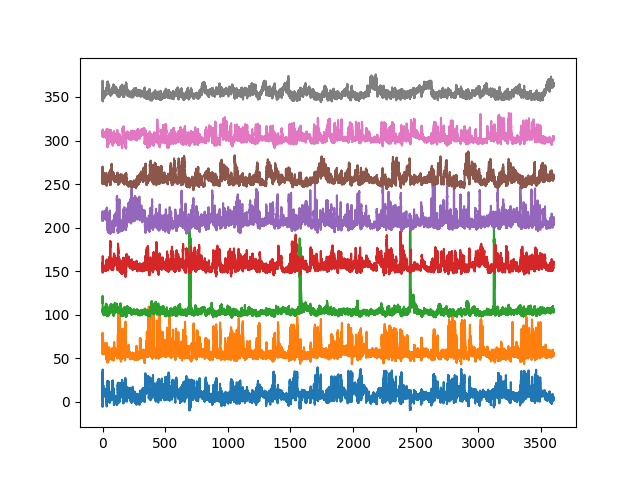

In [84]:
plt.figure()
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  factors_temporal_nmf.T*3000 + 20 + 50*np.arange(rank)[None,:]);

plt.figure()
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  scores_nmf.T + 50*np.arange(rank)[None,:]);
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  scores_nmf_orth.T + 50*np.arange(rank)[None,:]);

plt.figure()
plt.plot(np.arange(factors_temporal_nmf.shape[1])/Fs,  scores_nmf_orth_ms.T + 50*np.arange(rank)[None,:]);

<IPython.core.display.Javascript object>


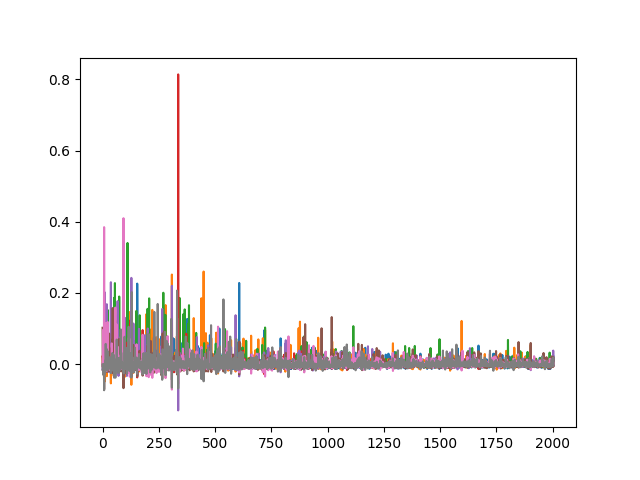

In [85]:
plt.figure()
plt.plot(factors_neuron_nmf_orth_ms_ordered.T);

<IPython.core.display.Javascript object>


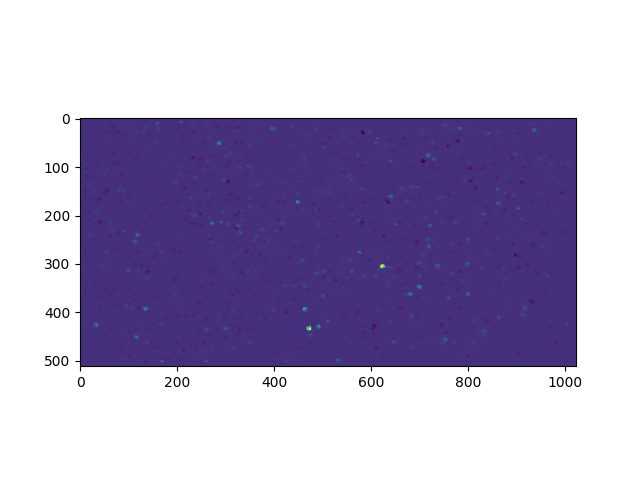

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [86]:
weights = factors_neuron_nmf_orth_ms_ordered.T.copy()
sf_weights = (sf[iscell].T * weights).T.reshape(rank, data_rois.FOV_height, data_rois.FOV_width)

%matplotlib notebook
roicat.visualization.display_toggle_image_stack(
    sf_weights, 
    clim=[sf_weights.min()/4, sf_weights.max()/4]
)

In [87]:
weights = factors_neuron_nmf_orth_ms_ordered.copy()

In [88]:
import sklearn

<IPython.core.display.Javascript object>


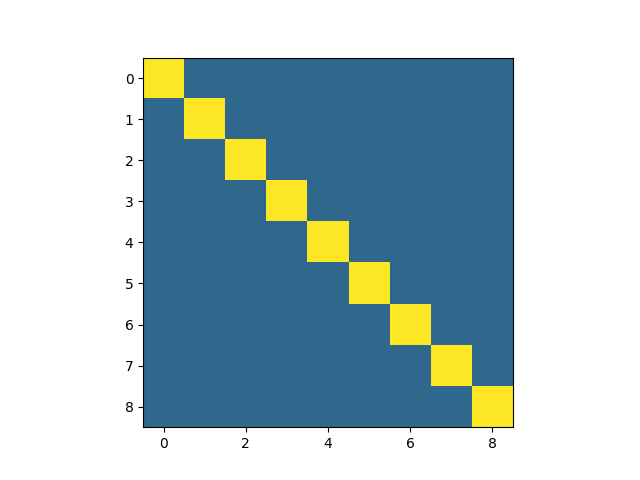

In [92]:
plt.figure()
plt.imshow(sklearn.metrics.pairwise.cosine_similarity(np.concatenate((weights, np.ones(weights.shape[1])[None,:]), axis=0)), vmin=-0.5, vmax=1)


visualization of final traces and masks

# Save it all

In [95]:
weights_day0 = {
#     "weights": weights[:,factor_to_use],
    "weights_all" : weights,
    "iscell_custom": iscell,
#     "factor_to_use": factor_to_use,
    "sf_weights": sf_weights,
#     "factors_temporal": factors_temporal_tokeep,
    "factors_temporal": scores_nmf_orth_ms_ordered,
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

# Load in old outputs

In [1]:
import numpy as np

In [2]:
data = np.load(r'D:/RH_local/data/BMI_cage_1511_4/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [3]:
data.keys()

dict_keys(['weights', 'weights_all', 'iscell_custom', 'factor_to_use', 'sf_weights', 'factors_temporal'])

In [6]:
import bnpm.plotting_helpers

<IPython.core.display.Javascript object>


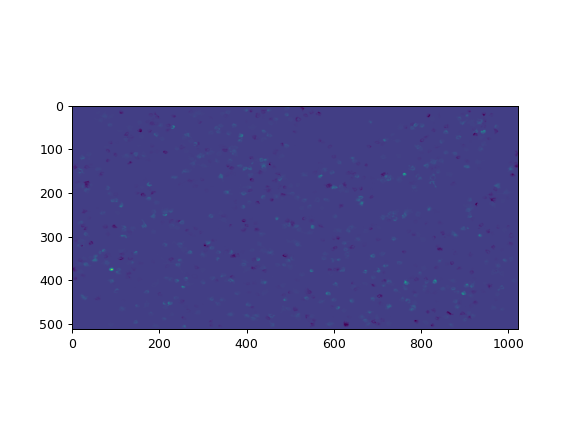

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [17]:
# weights = theta[:,np.argsort(evrs)[::-1]]
# sf_weights = np.einsum('ij,ikl->jkl', data['weights_all'], sf[data['iscell_custom']])

%matplotlib notebook
bnpm.plotting_helpers.display_toggle_image_stack(data['sf_weights'])

In [ ]:
components , scores , explained_variance_ratio_ , stds = decomposition.simple_pca(neural_data_toUse.T.cpu().numpy() , n_components=None , mean_sub=True, zscore=False, plot_pref=True , n_PCs_toPlot=2)

In [ ]:
factors_orth_regression.shape

In [8]:
Fs = 30

In [10]:
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


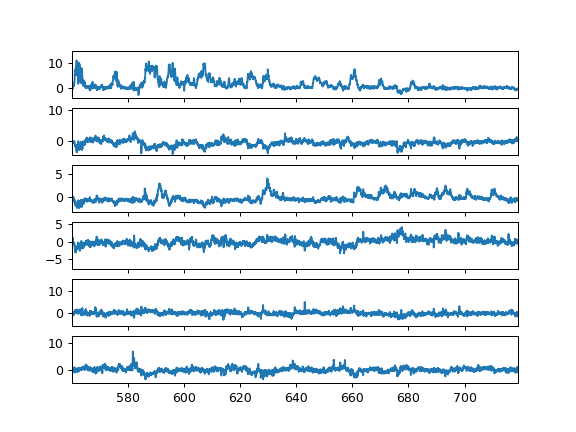

In [18]:
%matplotlib notebook
fig, axs = plt.subplots(data['factors_temporal'].shape[0], 1, sharex=True)
for ii in range(axs.shape[0]):
#     axs[ii,0].plot(np.arange(data['factors_temporal'].shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[-ii-1],:].T)
    axs[ii].plot(np.arange(data['factors_temporal'].shape[1])/Fs, data['factors_temporal'][ii])

<IPython.core.display.Javascript object>


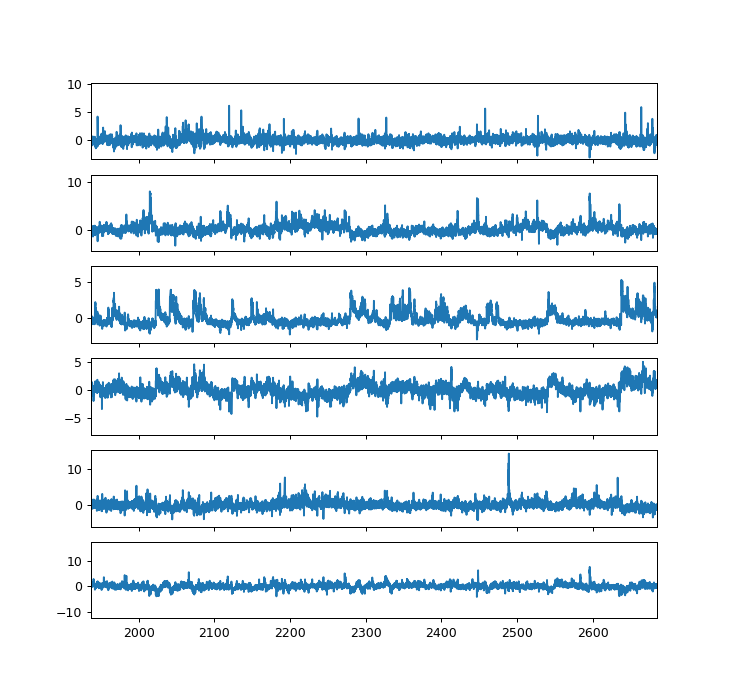

In [14]:
%matplotlib notebook
fig, axs = plt.subplots(data['factors_temporal'].shape[0], 1, sharex=True)
for ii in range(axs.shape[0]):
#     axs[ii,0].plot(np.arange(data['factors_temporal'].shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[-ii-1],:].T)
    axs[ii].plot(np.arange(data['factors_temporal'].shape[1])/Fs, data['factors_temporal'][ii])

<IPython.core.display.Javascript object>


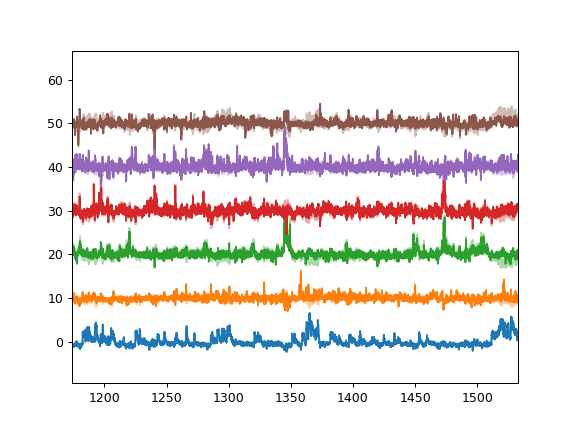

In [372]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good))

In [ ]:
import rastermap

In [ ]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
#     nPC=200,
#     init='pca',
#     alpha=1.0,
#     K=1.0,
#     mode='basic',
#     verbose=True,
#     annealing=True,
#     constraints=2,
)

In [ ]:
# embedding = rmap.fit_transform(neural_data_toUse.cpu().numpy())
# embedding = rmap.fit_transform(dFoF)
embedding = rmap.fit_transform(np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression]))

In [ ]:
plt.figure()
plt.hist(embedding, 400);
plt.hist(embedding[-10:], 100);

In [ ]:
plt.figure()
plt.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
plt.xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1,sharex=True)
ax1.imshow(
#     timeSeries.scale_between(neural_data_toUse.cpu().numpy()[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     timeSeries.scale_between(spks_s2p[rmap.isort], lower_percentile=10, upper_percentile=90), 
#     dFoF[rmap.isort], vmax=5, 
    np.concatenate([neural_data_toUse.cpu().numpy()[:,indices_to_use], factors_orth_regression])[rmap.isort], 
    vmin=0,
    vmax=5, 
    aspect='auto',
#     extent=[0, indices_to_use.max()/Fs, 0, neural_data_toUse.shape[0]]
)
#ax1.set_xticks(ticks=np.arange(0,factors_temporal_tokeep.shape[1], 10000), labels=np.round(np.arange(0,factors_temporal_tokeep.shape[1], 10000)/Fs))
ax2.plot(factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(10),alpha=0.4)
ax2.plot(factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(10))

In [ ]:
indices_to_use.shape